In [109]:
!pip install snntorch

In [110]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools
import pandas as pd 

from sklearn.metrics import confusion_matrix
import seaborn as sn

# 1. Setting up the Dataset

Get data from GitLab

In [111]:
#train_url="https://gitlab.com/schatz06/smart-grid-metering-ids/-/raw/main/NSLKDD/KDDTrain.txt"
#test_url= "https://gitlab.com/schatz06/smart-grid-metering-ids/-/raw/main/NSLKDD/KDDTest.txt"
#TRAIN_FILE="KDDTrain.txt"
#TEST_FILE="KDDTest.txt"

In [112]:
class MyDataset(Dataset):

  def __init__(self,file_name):
    price_df=pd.read_csv(file_name)

    x=price_df.iloc[:,:-1].values
    y=price_df.iloc[:,-1].values
    print(x)
    print(y)
    self.x_train=torch.tensor(x,dtype=torch.float32)
    self.y_train=torch.tensor(y,dtype=torch.long)

  def __len__(self):
    return len(self.y_train)
  
  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

In [113]:
batch_size = 128
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

trainDs=MyDataset('train_binary.csv')
testDs=MyDataset('test_binary.csv')
train_loader = DataLoader(trainDs, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(testDs, batch_size=batch_size, shuffle=True, drop_last=True)

[[0.00000000e+00 3.55806412e-07 0.00000000e+00 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.05799870e-07 0.00000000e+00 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 1.61670897e-06 2.93143779e-07 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.09423153e-07 0.00000000e+00 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]]
[0 0 1 ... 0 1 0]
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.66113545e-05 9.40821721e-06 0.00000000e+00 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 3.95227734e-05 6.34686817e-06 ... 0.00000000e+00
  1.00000000e+

# 2. Define the Network

In [114]:
# Network Architecture
num_inputs = 122 # input layer neurons 
num_hidden = 1000 # hidden layer neurons 
num_outputs = 2 # output layer neurons /binary classification 

# Temporal Dynamics
num_steps = 25
beta = 0.95

In [115]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
        
# Load the network onto CUDA if available
net = Net().to(device)

The code in the `forward()` function will only be called once the input argument `x` is explicitly passed into `net`.

* `fc1` applies a linear transformation to all input pixels from the MNIST dataset;
* `lif1` integrates the weighted input over time, emitting a spike if the threshold condition is met;
* `fc2` applies a linear transformation to the output spikes of `lif1`;
* `lif2` is another spiking neuron layer, integrating the weighted spikes over time.

# 3. Training the SNN

## 3.1 Accuracy Metric
Below is a function that takes a batch of data, counts up all the spikes from each neuron (i.e., a rate code over the simulation time), and compares the index of the highest count with the actual target. If they match, then the network correctly predicted the target.

In [116]:
# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

## 3.2 Loss Definition
The `nn.CrossEntropyLoss` function in PyTorch automatically handles taking the softmax of the output layer as well as generating a loss at the output. 

In [117]:
loss = nn.CrossEntropyLoss()

## 3.3 Optimizer
Adam is a robust optimizer that performs well on recurrent networks, so let's use that with a learning rate of $5\times10^{-4}$. 

In [118]:
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

## 3.4 Training Loop

Let's combine everything into a training loop. We will train for one epoch (though feel free to increase `num_epochs`), exposing our network to each sample of data once.

In [119]:
num_epochs = 20
loss_hist = []
test_loss_hist = []
counter = 0

import time
start_time = time.time()


# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer()
            counter += 1
            iter_counter +=1

print("--- %s seconds ---" % (time.time() - start_time))

Epoch 0, Iteration 0
Train Set Loss: 86.40
Test Set Loss: 36.28
Train set accuracy for a single minibatch: 47.66%
Test set accuracy for a single minibatch: 48.44%


Epoch 0, Iteration 50
Train Set Loss: 6.16
Test Set Loss: 18.96
Train set accuracy for a single minibatch: 76.56%
Test set accuracy for a single minibatch: 57.03%


Epoch 0, Iteration 100
Train Set Loss: 5.10
Test Set Loss: 18.43
Train set accuracy for a single minibatch: 78.12%
Test set accuracy for a single minibatch: 60.16%


Epoch 0, Iteration 150
Train Set Loss: 3.50
Test Set Loss: 22.87
Train set accuracy for a single minibatch: 82.03%
Test set accuracy for a single minibatch: 62.50%


Epoch 0, Iteration 200
Train Set Loss: 3.67
Test Set Loss: 20.29
Train set accuracy for a single minibatch: 86.72%
Test set accuracy for a single minibatch: 60.16%


Epoch 0, Iteration 250
Train Set Loss: 3.12
Test Set Loss: 25.78
Train set accuracy for a single minibatch: 87.50%
Test set accuracy for a single minibatch: 64.84%


Epoch 

# 4. Results
## 4.1 Plot Training/Test Loss

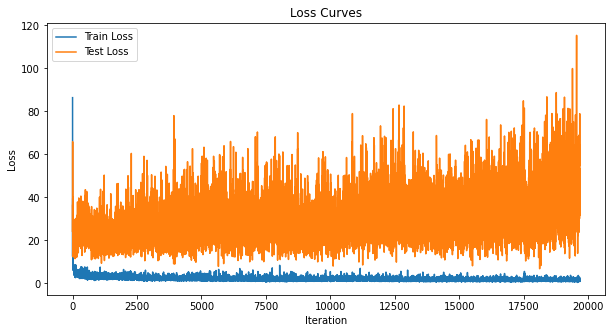

In [120]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

The loss curves are noisy because the losses are tracked at every iteration, rather than averaging across multiple iterations. 

## 4.2 Test Set Accuracy
This function iterates over all minibatches to obtain a measure of accuracy over the full samples in the test set.

Total correctly classified instances: 18477/22544
Test Set Accuracy: 81.96%
False alarm rate: 3.37%
Accuracy: 81.96%
Detection rate: 70.86%
Precision: 96.53%
Recall: 70.86%
F1-score: 81.72%
False positive rate: 3.47%
False negative rate: 28.50%


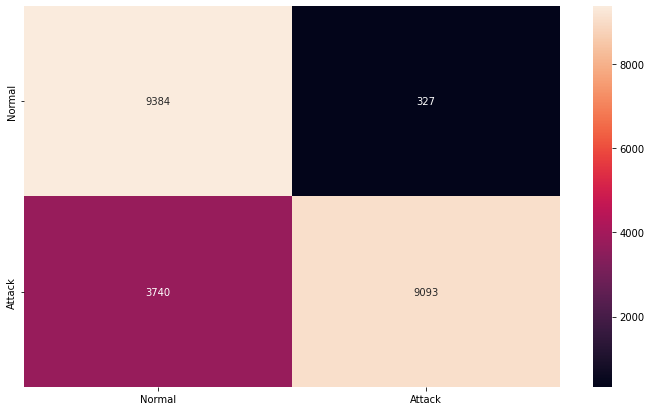

In [121]:
total = 0
correct = 0
y_pred = [] # for confusion matrix 
y_true = [] # for confusion matrix 
# drop_last switched to False to keep all samples
test_loader = DataLoader(testDs, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad(): # swithc of gradient computation
  net.eval() # switch for evaluation 
  for data, targets in test_loader: # load batch of data and targets
    data = data.to(device) # sent to gpu
    targets = targets.to(device) # sent to gpu 
    
    # forward pass
    test_spk, _ = net(data.view(data.size(0), -1)) # forward pass to predict 


    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    y_pred.extend(predicted.cpu()) # Save Prediction
    y_true.extend(targets.cpu())
    total += targets.size(0)
    correct += (predicted == targets).sum().item()


# constant for classes
classes = ('Normal', 'Attack')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = confusion_matrix(y_true,y_pred).ravel()
#print("tn",tn)
#print("fp",fp)
#print("fn",fn)
#print("tp",tp)
# rows is the truth , columns is the predicted 
# plot confusion matrix with actual numbers
df_cm= pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])


plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True,fmt ='g')

precision = (tp/(tp+fp))
recall = (tp/(tp+fn))

print(f"Total correctly classified instances: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")
print(f"False alarm rate: {100*(fp/(fp+tn)):.2f}%")
print(f"Accuracy: {100*((tp+tn)/(tp+fp+fn+tn)):.2f}%")
print(f"Detection rate: {100 *(tp/(tp+fn)):.2f}%")
print(f"Precision: {100 * precision:.2f}%")
print(f"Recall: {100 * recall:.2f}%")
print(f"F1-score: {100 *((2*precision*recall)/(precision+recall)):.2f}%")
print(f"False positive rate: {100*(fp/(fp+tp)):.2f}%")
print(f"False negative rate: {100*(fn/(fn+tn)):.2f}%")